<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Данные (0.5 балла)

In [ ]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [ ]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("./drive/MyDrive/lab8/data/image_codes.npy")
captions = json.load(open('./drive/MyDrive/lab8/data/captions_tokenized.json'))

CPU times: user 0 ns, sys: 837 ms, total: 837 ms
Wall time: 4.66 s



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [ ]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0)))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = nn.CrossEntropyLoss(ignore_index=pad_ix)(
        logits_for_next.view(-1, logits_for_next.shape[-1]),
        captions_ix_next.view(-1)
    )

    # Добавляем измерение, чтобы loss был формы [1]
    return loss.unsqueeze(0)

In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(network.parameters(), lr=1e-3)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [ ]:
from sklearn.model_selection import train_test_split
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = [captions[i] for i in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [ ]:
generate_batch(img_codes,captions,3)

(tensor([[0.1371, 0.6125, 0.7809,  ..., 0.3717, 1.4072, 0.1443],
         [0.4532, 0.1129, 0.0758,  ..., 0.2014, 0.0802, 0.1868],
         [0.0798, 0.0797, 0.4889,  ..., 0.0799, 0.7815, 0.0946]]),
 tensor([[   1,   24,  262,  301,  163,  315,  691,  572,   24, 3060,  442,   12,
             2],
         [   1,   24,   46,   93,   41,  181,  195, 4293,  163,  210,  145,   12,
             2],
         [   1,   24, 1257,   94,    6,   45, 9132,   14,  109,   89,    2,    3,
             3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [ ]:
batch_size = 20  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:11<00:00,  4.35it/s]



Epoch: 0, train loss: 6.1963887023925786, val loss: 5.063187980651856


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]



Epoch: 1, train loss: 4.93045859336853, val loss: 4.834335994720459


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]



Epoch: 2, train loss: 4.6360322284698485, val loss: 4.47285270690918


100%|██████████| 50/50 [00:08<00:00,  6.06it/s]



Epoch: 3, train loss: 4.454895763397217, val loss: 4.407488441467285


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]



Epoch: 4, train loss: 4.353777961730957, val loss: 4.2911012172698975


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]



Epoch: 5, train loss: 4.186038470268249, val loss: 4.2958550453186035


100%|██████████| 50/50 [00:08<00:00,  6.16it/s]



Epoch: 6, train loss: 4.109256043434143, val loss: 4.256803750991821


100%|██████████| 50/50 [00:08<00:00,  5.68it/s]



Epoch: 7, train loss: 4.071272807121277, val loss: 3.8387325286865233


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]



Epoch: 8, train loss: 3.9862408447265625, val loss: 3.9481309413909913


100%|██████████| 50/50 [00:08<00:00,  5.83it/s]



Epoch: 9, train loss: 3.9200168466567993, val loss: 3.9485664844512938


100%|██████████| 50/50 [00:09<00:00,  5.46it/s]



Epoch: 10, train loss: 3.9010991764068605, val loss: 3.847788953781128


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]



Epoch: 11, train loss: 3.8279230642318725, val loss: 3.9036929607391357


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]



Epoch: 12, train loss: 3.81302659034729, val loss: 3.8539413928985597


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]



Epoch: 13, train loss: 3.732544627189636, val loss: 3.7524417877197265


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]



Epoch: 14, train loss: 3.7211590099334715, val loss: 3.774318552017212


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]



Epoch: 15, train loss: 3.6487797117233276, val loss: 3.572076749801636


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]



Epoch: 16, train loss: 3.619648480415344, val loss: 3.6278759956359865


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]



Epoch: 17, train loss: 3.5312049198150635, val loss: 3.4219107627868652


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]



Epoch: 18, train loss: 3.5874643421173094, val loss: 3.6463157176971435


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]



Epoch: 19, train loss: 3.49200325012207, val loss: 3.5240478515625


100%|██████████| 50/50 [00:08<00:00,  5.96it/s]



Epoch: 20, train loss: 3.4778896713256837, val loss: 3.4421693801879885


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]



Epoch: 21, train loss: 3.4144048738479613, val loss: 3.430588960647583


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]



Epoch: 22, train loss: 3.418936562538147, val loss: 3.264346694946289


100%|██████████| 50/50 [00:09<00:00,  5.41it/s]



Epoch: 23, train loss: 3.3771706771850587, val loss: 3.3979212284088134


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]



Epoch: 24, train loss: 3.3377140951156616, val loss: 3.4100106716156007


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]



Epoch: 25, train loss: 3.3586975860595705, val loss: 3.351418876647949


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]



Epoch: 26, train loss: 3.247879886627197, val loss: 3.2955417156219484


100%|██████████| 50/50 [00:08<00:00,  5.99it/s]



Epoch: 27, train loss: 3.3303502941131593, val loss: 3.2913288116455077


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]



Epoch: 28, train loss: 3.319035167694092, val loss: 3.4680337429046633


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]



Epoch: 29, train loss: 3.2451162576675414, val loss: 3.4059370517730714


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]



Epoch: 30, train loss: 3.2434009313583374, val loss: 3.3308058738708497


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]



Epoch: 31, train loss: 3.248151431083679, val loss: 3.1617972373962404


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]



Epoch: 32, train loss: 3.2407548904418944, val loss: 3.3356364250183104


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]



Epoch: 33, train loss: 3.1763999891281127, val loss: 3.204002857208252


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]



Epoch: 34, train loss: 3.1679845333099363, val loss: 3.3035769939422606


100%|██████████| 50/50 [00:09<00:00,  5.38it/s]



Epoch: 35, train loss: 3.189046025276184, val loss: 3.085965394973755


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]



Epoch: 36, train loss: 3.191690721511841, val loss: 3.2815450191497804


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 37, train loss: 3.157160816192627, val loss: 3.2017660617828367


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 38, train loss: 3.251229848861694, val loss: 3.1350056648254396


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]



Epoch: 39, train loss: 3.0841320753097534, val loss: 3.1624494075775145


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]



Epoch: 40, train loss: 3.119219570159912, val loss: 3.252876091003418


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 41, train loss: 3.0873723363876344, val loss: 3.227483940124512


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]



Epoch: 42, train loss: 3.1044883251190187, val loss: 3.1476051807403564


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]



Epoch: 43, train loss: 3.0946655225753785, val loss: 2.9624456405639648


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 44, train loss: 3.030287857055664, val loss: 2.885266590118408


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]



Epoch: 45, train loss: 3.0966131925582885, val loss: 3.142916679382324


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]



Epoch: 46, train loss: 3.130023226737976, val loss: 3.1115285873413088


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]



Epoch: 47, train loss: 3.109840068817139, val loss: 3.207722282409668


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]



Epoch: 48, train loss: 3.0443217611312865, val loss: 3.120947074890137


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]



Epoch: 49, train loss: 3.0252926969528198, val loss: 2.87050838470459


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]



Epoch: 50, train loss: 2.979075412750244, val loss: 3.0274783611297607


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]



Epoch: 51, train loss: 2.9934766340255736, val loss: 2.962961435317993


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]



Epoch: 52, train loss: 3.027935810089111, val loss: 3.0044764041900636


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]



Epoch: 53, train loss: 3.0646302795410154, val loss: 3.2047336101531982


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 54, train loss: 2.9525590991973876, val loss: 2.8971585273742675


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]



Epoch: 55, train loss: 3.0498175477981566, val loss: 2.7916473388671874


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]



Epoch: 56, train loss: 2.994871425628662, val loss: 3.0103009700775147


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 57, train loss: 3.0011613988876342, val loss: 2.8155011177062987


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]



Epoch: 58, train loss: 2.9713804435729982, val loss: 2.894470548629761


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]



Epoch: 59, train loss: 3.037301344871521, val loss: 3.017361879348755


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]



Epoch: 60, train loss: 2.9678923797607424, val loss: 3.0860313415527343


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]



Epoch: 61, train loss: 2.9211748218536377, val loss: 2.9402074337005617


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]



Epoch: 62, train loss: 2.9655209970474243, val loss: 3.0356507301330566


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]



Epoch: 63, train loss: 2.90883321762085, val loss: 2.9923686504364015


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]



Epoch: 64, train loss: 2.940949730873108, val loss: 2.9249153614044188


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 65, train loss: 2.9109894037246704, val loss: 3.034040021896362


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]



Epoch: 66, train loss: 2.9302447843551636, val loss: 2.903889799118042


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]



Epoch: 67, train loss: 2.8992084312438964, val loss: 2.78871111869812


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]



Epoch: 68, train loss: 2.9534055280685423, val loss: 2.99804048538208


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]



Epoch: 69, train loss: 2.8654132747650145, val loss: 2.9999593257904054


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]



Epoch: 70, train loss: 2.9157256507873535, val loss: 3.006534242630005


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]



Epoch: 71, train loss: 2.927018175125122, val loss: 2.880031394958496


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]



Epoch: 72, train loss: 2.867027311325073, val loss: 2.9125969409942627


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]



Epoch: 73, train loss: 2.877262330055237, val loss: 2.751783084869385


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]



Epoch: 74, train loss: 2.8707197380065916, val loss: 2.9283702850341795


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]



Epoch: 75, train loss: 2.8764017248153686, val loss: 2.8146820068359375


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]



Epoch: 76, train loss: 2.842726454734802, val loss: 2.9540200233459473


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]



Epoch: 77, train loss: 2.816265001296997, val loss: 2.80865740776062


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]



Epoch: 78, train loss: 2.9233591461181643, val loss: 2.8635640144348145


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]



Epoch: 79, train loss: 2.889022855758667, val loss: 2.876366472244263


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]



Epoch: 80, train loss: 2.837095384597778, val loss: 2.9563549995422362


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]



Epoch: 81, train loss: 2.826932444572449, val loss: 3.020381498336792


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]



Epoch: 82, train loss: 2.87009126663208, val loss: 3.028603458404541


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]



Epoch: 83, train loss: 2.8815073013305663, val loss: 2.8050928115844727


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 84, train loss: 2.8690290117263793, val loss: 2.953893518447876


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]



Epoch: 85, train loss: 2.7733864545822144, val loss: 2.8994900226593017


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]



Epoch: 86, train loss: 2.796568570137024, val loss: 2.7938531398773194


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]



Epoch: 87, train loss: 2.848024764060974, val loss: 2.777314281463623


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]



Epoch: 88, train loss: 2.7964496088027953, val loss: 2.57377552986145


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]



Epoch: 89, train loss: 2.831415729522705, val loss: 2.8860925674438476


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]



Epoch: 90, train loss: 2.7934485149383543, val loss: 2.9897642612457274


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]



Epoch: 91, train loss: 2.8060621356964113, val loss: 2.710728645324707


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]



Epoch: 92, train loss: 2.84469587802887, val loss: 2.720856475830078


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]



Epoch: 93, train loss: 2.7802170848846437, val loss: 2.656215047836304


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]



Epoch: 94, train loss: 2.787143521308899, val loss: 2.7487081050872804


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]



Epoch: 95, train loss: 2.814218544960022, val loss: 3.1231889724731445


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]



Epoch: 96, train loss: 2.7851123428344726, val loss: 2.7804487705230714


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]



Epoch: 97, train loss: 2.7737173366546632, val loss: 2.7520948886871337


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]



Epoch: 98, train loss: 2.7930143213272096, val loss: 2.907415533065796


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]



Epoch: 99, train loss: 2.81681209564209, val loss: 2.7119834423065186
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [ ]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 132MB/s]


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [ ]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [ ]:
import os
from matplotlib import pyplot as plt
from skimage.transform import resize
%matplotlib inline

os.makedirs('data', exist_ok=True)
#sample image

!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

--2025-10-30 10:25:13--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-30 10:25:13--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K   281KB/s    in 0.2s    

2025-10-30 10:25:14 (281 KB/s) - ‘data/img.jpg’ saved [54731/5473

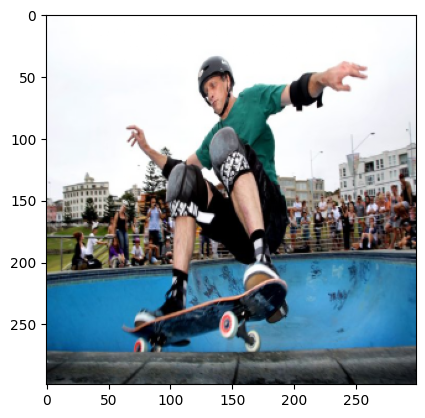

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

a man carrying a skateboard doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man is riding a skateboard on a skateboard
a man jumping a skateboard trick down a ramp .
a man in a black shirt is riding a skateboard .
a man in a red shirt is doing a trick
a man ridding a skateboard trick in a skate park .
a man on a skateboard doing a trick .
a man in a blue shirt riding a skateboard on a skateboard .


--2025-10-30 10:25:28--  https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246925 (241K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 241.14K  --.-KB/s    in 0.004s  

2025-10-30 10:25:29 (65.9 MB/s) - ‘data/img.jpg’ saved [246925/246925]



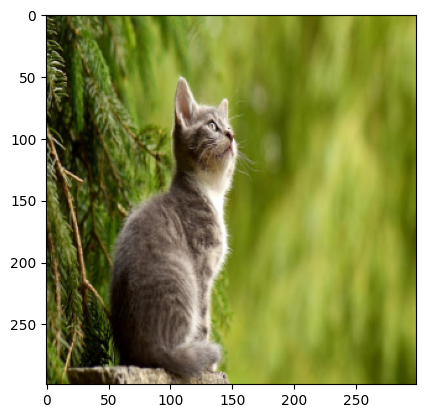

two small cats are sitting on a wooden surface .
a cat laying on top of a brick wall .
a cat is looking at a window of a window .
a cat laying on a wooden chair next to a cat .
a cat sitting on a wooden bench in a room .
a cat sitting on a desk near a window .
a cat laying on the back of a window sill .
a cat is laying on a cat in the middle of a wooden chair .
a cat is standing on the back of a car .
a cat sitting on a couch in a park .


In [ ]:
!wget https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

In [ ]:
def network_applying(f_path):
  all_images = os.listdir(f_path)

  for name in all_images:
    if not name.lower().endswith(('.jpg', '.png', '.jpeg')):
      continue

    path = os.path.join(f_path, name)
    img = plt.imread(path)
    img = resize(img, (299, 299))

    plt.imshow(img)
    plt.show()

    for i in range(5):
      print(' '.join(generate_caption(img, t=2.)[1:-1]))

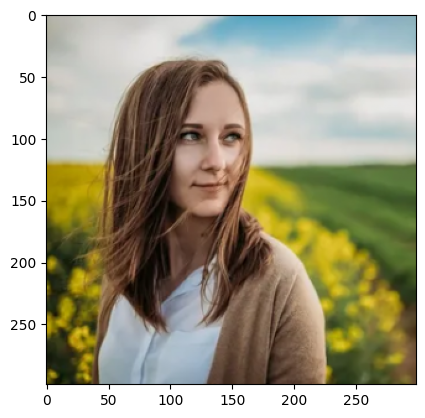

a woman eating a horse next to a green grass .
a woman standing next to a bench on a bench .
a woman holding a frisbee in his hand holding a colorful umbrella .
a woman holding a green frisbee in a park .
a man in a green shirt holding a frisbee in his mouth .


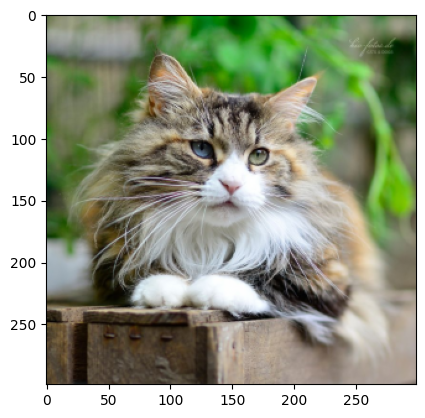

a black cat laying on a wooden bench .
a cat is looking at a laptop computer .
a cat is standing on the ground beside a building .
a cat sitting on the floor of a room .
a cat sits on the side of a wooden bench .


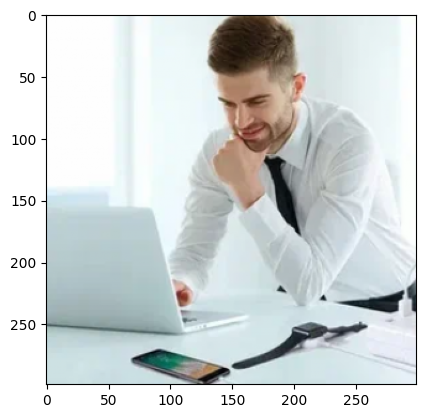

a man in a suit and tie on his back board .
a man with a tie in his hands .
a man and a woman on a phone in a room .
a man is wearing a hat and tie .
a man in a black shirt holding a toothbrush


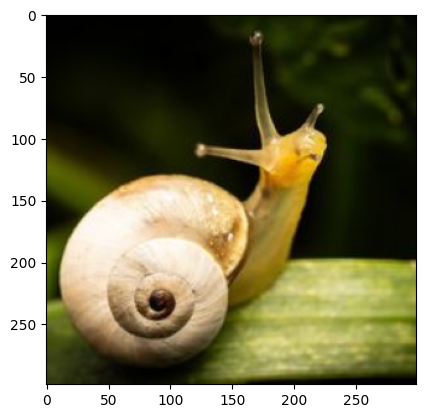

a close up of a baby elephant in a yard .
a large elephant that is in the water .
a couple of elephants standing next to each other .
a large brown bear is standing on a branch .
a little girl holding a large kite on a rock


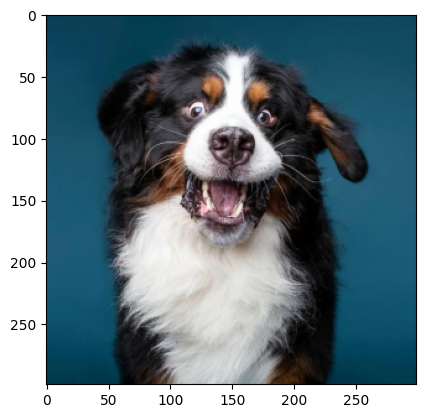

a dog laying on top of a wooden fence .
a dog is laying on the ground with a mirror .
a dog standing next to a small dog .
a dog with a bird perched on a blue plate .
a dog is standing in the grass next to a green plant .


In [ ]:
# easy
f_path = 'drive/MyDrive/lab8/images/easy/'
network_applying(f_path)

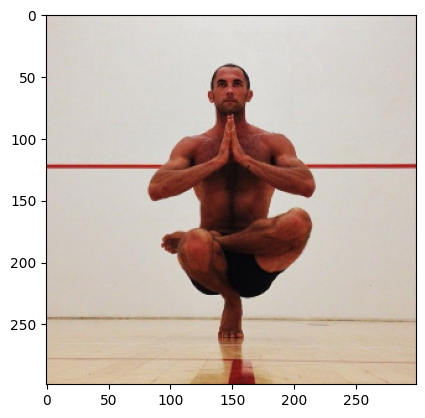

a couple of birds sitting on a branch with a tree .
a small bird is sitting in the middle of a fence .
a dog is standing on the ground with a green #UNK# .
a dog is standing next to a fire hydrant .
a bunch of different types of #UNK# in a field .


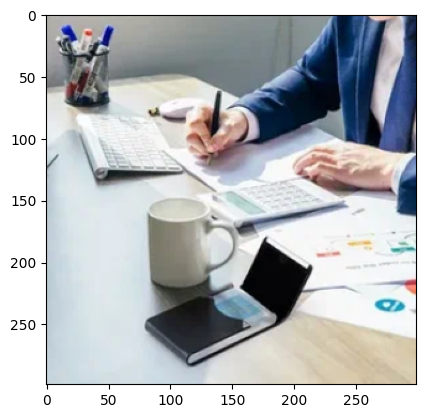

a man is holding a cake with a knife .
a man in a room holding a small slice of pizza
a man putting a cake with a little girl in her hand .
a man standing next to a pizza in a room
a man and a woman with a baby cake .


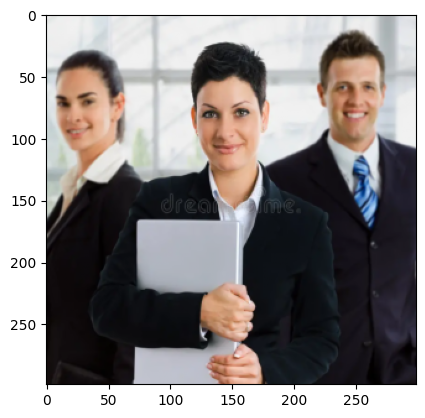

a man is wearing a shirt and tie .
a man wearing a hat and tie sitting on a wooden table .
a man in a suit and tie next to a basket .
a man in a suit with a tie
a man in a suit and tie with a shirt and tie .


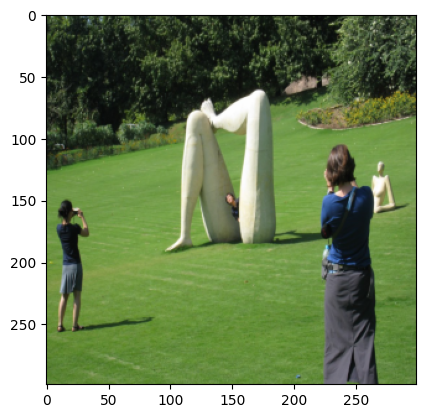

a man holding a frisbee in his hand .
a man in a field with a surf board on a beach .
a man that is standing on a field with a frisbee .
a man in a grassy field with a frisbee in the background
a man is throwing a frisbee while another man is flying a kite .


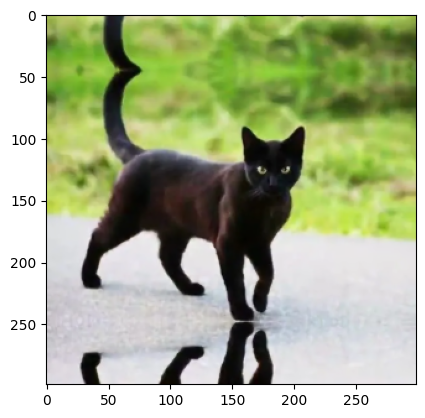

a cat is standing on the floor of a window .
a cat is laying on the top of a book .
a cat is sitting on a small truck with a phone
a cat is holding a remote control on a laptop .
a cat sitting on top of a white toilet .


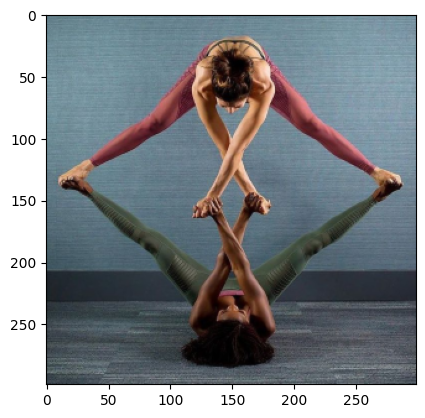

a man flying a kite in a park with a frisbee .
a man is holding a dog in the air .
a man is holding a surfboard with his surfboard .
a person is riding a wave on a surfboard .
a woman is sitting on the beach with a surfboard .


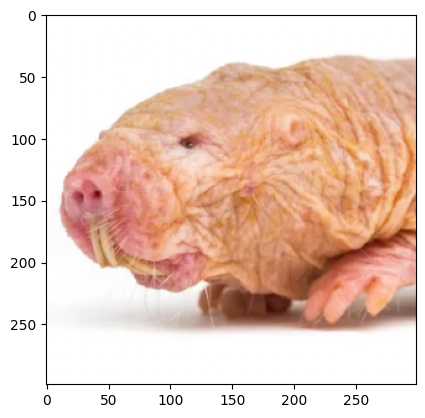

a cat sitting on the ground with a piece of it
a cat is sitting on the side of a bed .
a cat is sitting on a table with a pair of scissors .
a cat is sitting on a wooden table .
a cat is laying on a white plate .


In [ ]:
# hard
f_path = 'drive/MyDrive/lab8/images/hard/'
network_applying(f_path)


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
